# Anti-spam filter using NLP

We are going to analyse a data set of 5.574 SMS phone messages in order to build a model that can distinguish a normal message (commonly known as "ham") from a spam.

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
import string

In [2]:
#downloading stopwords package from Natural Language Toolkit
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


        C:\Users\Gabriela\AppData\Roaming\nltk_data...
      Unzipping corpora\stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


**Loading the Data**

In [3]:
msg = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [9]:
msg[1]

'ham\tOk lar... Joking wif u oni...'

In [8]:
msg[2]

"spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

As we can see, it is a tab separated file (\t), where the first column is a label that identifies the message as "ham" or "spam". The second column is the message itself.

Let's load the data using pandas

In [11]:
msg_df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep ='\t', names = ['label', 'message'])

In [12]:
msg_df.head(3)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


**Exploratory Data Analysis**

In [13]:
msg_df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Taking a first look at the Data, we can see that the number of unique messages is less than the total, which implies there are repeated messages.
Let's take a look at the same parameters grouped by the labels.

In [14]:
msg_df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

There are much more ham messages than spam.

Let's analyse the **length** of the messages:

In [18]:
msg_df['length'] = msg_df['message'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029D18F1F160>,
      dtype=object)

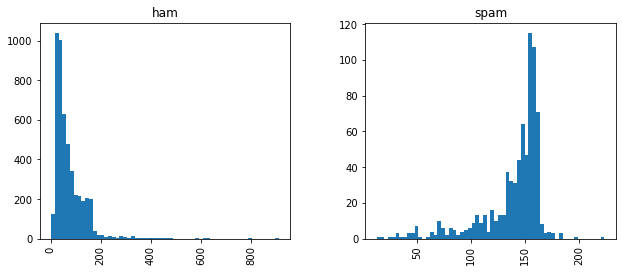

In [22]:
msg_df.hist(column='length', by='label', bins=60, figsize=(10,4))

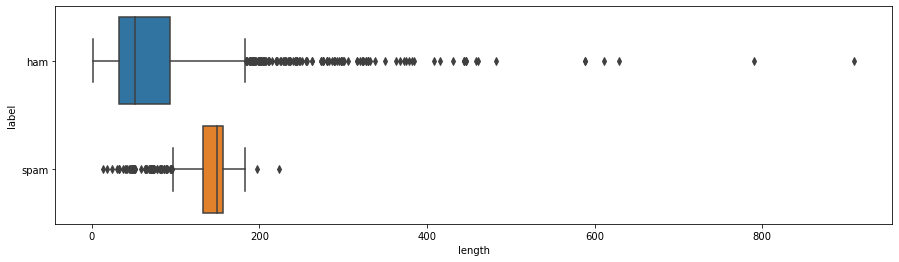

In [61]:
plt.figure(figsize=(15,4))
sns.boxplot(y='label',x='length', data=msg_df)

We can see that in general, spam messages are longer. Most of the messages are around 150 characters. While the ham messages are in general less than 100 characteres. However, the ham messages have more outliers that have more than 300 characters, while spam messages do not pass 250 characters.
Now let's do some cleaning in the messages, in order to give to the model just the relevant words to distinguish the classes.

**Tokenization: Eliminate puntuction, capitalization and stopwords**

In [35]:
from nltk.corpus import stopwords

In [50]:
def text_cleaning(msg):
    no_punc = [char for char in msg if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    lower_c = no_punc.lower()
    return [word for word in lower_c.split() if word not in stopwords.words('english')]

**Vectorization: Transform the list of words in vectors**

In the vectorization process we will transform the list of words in vectors the SciKit Learn's algorithm models can work with.

There are basically 3 steps to do it:
1. Count how many times does a word appears in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
count_matrix = CountVectorizer(analyzer=text_cleaning).fit(msg_df['message'])

In [52]:
print(len(count_matrix.vocabulary_))

9530


In [54]:
messages_bow = count_matrix.transform(msg_df['message'])

In [56]:
messages_bow.shape

(5572, 9530)

At this step we produced a matrix that takes every unique word as a column, and each message as a row. We fillup this matrix with the number of times the word in the column appears in the respective message in the row.

Since not every message will have the same words, this matrix will have many zeros in it. This kind of matrix is known as Sparse Matrix, and in order to save space, the zero values are not stored.

Now we have a Sparse Matrix with:
* 5.572 rows: representing the number of messages;
* 9.530 columns: representing the unique words;

Let's go to step 2 and 3:

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer

In [63]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [65]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

At this step we transform the count of words in a frequency:

* Tf(t) = term frequency = (Number of times term t appears in a document) / (Total number of terms in the document)

Then, we interpretate that despite the stopwords already cleaned up, it may still have certain terms that repeats too much in the messages, such as "that" or "if", which have little importance to the model purpose. Thus we need to weigh down the frequent terms, while scale up the rare ones.

* Idf(t) = inverse document frequency = log_e(Total number of documents / Number of documents with term t in it)

With messages represented as vectors, we can finally train our spam/ham classifier. It is possible to use almost any sort of classification algorithms. Let's try the Naive Bayes classifier algorithm.

**Train Test Split**

In [67]:
from sklearn.model_selection import train_test_split

In [69]:
X = messages_tfidf
y = msg_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Training the Model**

In [70]:
from sklearn.naive_bayes import MultinomialNB
spam_detect = MultinomialNB().fit(X_train, y_train)

**Evaluating the Model**

In [71]:
predictions = spam_detect.predict(X_test)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1444
        spam       1.00      0.65      0.79       228

    accuracy                           0.95      1672
   macro avg       0.97      0.83      0.88      1672
weighted avg       0.96      0.95      0.95      1672

[[1444    0]
 [  79  149]]


As we can see, the model have a great accuracy of 95%. All the ham messages were correctly classified, while the spams had some errors. In this case, is better having false negatives than false positives. It is better to see some spams, than filtering a ham message that could be important to the user.